# 06 - Normalização e Comparações Finais

## CRISP-DM: Fase de Avaliação (Evaluation)

Este notebook realiza a avaliação final de todos os modelos desenvolvidos no projeto D4Maia, comparando:

1. **Clustering com e sem normalização** - Impacto no K-Means e DBSCAN
2. **Modelos de Séries Temporais** - Baseline vs ARIMA vs LSTM
3. **Modelos Supervisionados com Features** - RF, XGBoost, MLP (com/sem normalização)
4. **Comparação entre abordagens** - Séries diretas vs Features agregadas
5. **Ligação ao contexto de negócio** - Utilidade prática das previsões

---

**Autor:** D4Maia Project Team  
**Data:** Dezembro 2025  
**UC:** Introdução à Aprendizagem Automática - MEI 2025/2026

## 1. Importação de Bibliotecas

In [1]:
# Bibliotecas essenciais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import os

# Configurações
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Cores para visualizações
COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Paleta para heatmaps
CMAP = 'RdYlGn_r'  # Verde (bom) -> Vermelho (mau) para erros

print("Bibliotecas importadas com sucesso!")
print(f"Data de execução: {datetime.now().strftime('%Y-%m-%d %H:%M')}")

Bibliotecas importadas com sucesso!
Data de execução: 2026-01-03 15:58


## 2. Carregamento dos Resultados

In [2]:
# Carregar todos os resultados dos notebooks anteriores
print("A carregar resultados dos notebooks anteriores...")
print("=" * 60)

# Resultados de Clustering (notebook 03)
try:
    df_clusters = pd.read_csv('data/intermediate/d4maia_cpe_clusters.csv')
    print(f"✓ Clusters: {len(df_clusters)} CPEs com clusters atribuídos")
except FileNotFoundError:
    print("✗ Ficheiro de clusters não encontrado")
    df_clusters = None

# Resultados de Séries Temporais (notebook 04)
try:
    df_ts_results = pd.read_csv('data/intermediate/d4maia_ts_results.csv')
    print(f"✓ Séries Temporais: {len(df_ts_results)} resultados (Baseline/ARIMA/LSTM)")
except FileNotFoundError:
    print("✗ Ficheiro de resultados de séries temporais não encontrado")
    df_ts_results = None

# Resultados de Modelos Supervisionados (notebook 05)
try:
    df_feature_results = pd.read_csv('data/intermediate/d4maia_feature_models_results.csv')
    print(f"✓ Modelos Supervisionados: {len(df_feature_results)} resultados (RF/XGB/MLP)")
except FileNotFoundError:
    print("✗ Ficheiro de resultados de modelos supervisionados não encontrado")
    df_feature_results = None

# Features por CPE (notebook 02)
try:
    df_features = pd.read_csv('data/intermediate/d4maia_cpe_features.csv')
    print(f"✓ Features por CPE: {len(df_features)} CPEs")
except FileNotFoundError:
    print("✗ Ficheiro de features não encontrado")
    df_features = None

print("\nCarregamento concluído!")

A carregar resultados dos notebooks anteriores...
✓ Clusters: 74 CPEs com clusters atribuídos
✓ Séries Temporais: 30 resultados (Baseline/ARIMA/LSTM)
✓ Modelos Supervisionados: 57 resultados (RF/XGB/MLP)
✓ Features por CPE: 89 CPEs

Carregamento concluído!


## 3. Avaliação de Clustering com e sem Normalização

Análise do impacto da normalização nos algoritmos de clustering.

In [3]:
if df_clusters is not None:
    print("ANÁLISE DE CLUSTERING")
    print("=" * 70)
    
    # Verificar colunas disponíveis
    print(f"\nColunas disponíveis: {df_clusters.columns.tolist()}")
    
    # Estatísticas dos clusters K-Means
    if 'cluster_kmeans' in df_clusters.columns:
        print(f"\n📊 K-Means:")
        kmeans_dist = df_clusters['cluster_kmeans'].value_counts().sort_index()
        print(f"   Número de clusters: {df_clusters['cluster_kmeans'].nunique()}")
        print(f"   Distribuição:")
        for cluster, count in kmeans_dist.items():
            pct = count / len(df_clusters) * 100
            print(f"     Cluster {cluster}: {count} CPEs ({pct:.1f}%)")
    
    # Estatísticas dos clusters DBSCAN
    if 'cluster_dbscan' in df_clusters.columns:
        print(f"\n📊 DBSCAN:")
        dbscan_dist = df_clusters['cluster_dbscan'].value_counts().sort_index()
        n_noise = (df_clusters['cluster_dbscan'] == -1).sum()
        n_clusters = df_clusters['cluster_dbscan'].nunique() - (1 if -1 in df_clusters['cluster_dbscan'].values else 0)
        print(f"   Número de clusters: {n_clusters}")
        print(f"   Pontos de ruído: {n_noise} ({n_noise/len(df_clusters)*100:.1f}%)")
        print(f"   Distribuição:")
        for cluster, count in dbscan_dist.items():
            label = "Ruído" if cluster == -1 else f"Cluster {cluster}"
            pct = count / len(df_clusters) * 100
            print(f"     {label}: {count} CPEs ({pct:.1f}%)")
else:
    print("Dados de clustering não disponíveis.")

ANÁLISE DE CLUSTERING

Colunas disponíveis: ['CPE', 'cluster_kmeans', 'cluster_dbscan']

📊 K-Means:
   Número de clusters: 8
   Distribuição:
     Cluster 0: 1 CPEs (1.4%)
     Cluster 1: 6 CPEs (8.1%)
     Cluster 2: 6 CPEs (8.1%)
     Cluster 3: 9 CPEs (12.2%)
     Cluster 4: 15 CPEs (20.3%)
     Cluster 5: 12 CPEs (16.2%)
     Cluster 6: 18 CPEs (24.3%)
     Cluster 7: 7 CPEs (9.5%)

📊 DBSCAN:
   Número de clusters: 3
   Pontos de ruído: 11 (14.9%)
   Distribuição:
     Ruído: 11 CPEs (14.9%)
     Cluster 0: 50 CPEs (67.6%)
     Cluster 1: 10 CPEs (13.5%)
     Cluster 2: 3 CPEs (4.1%)


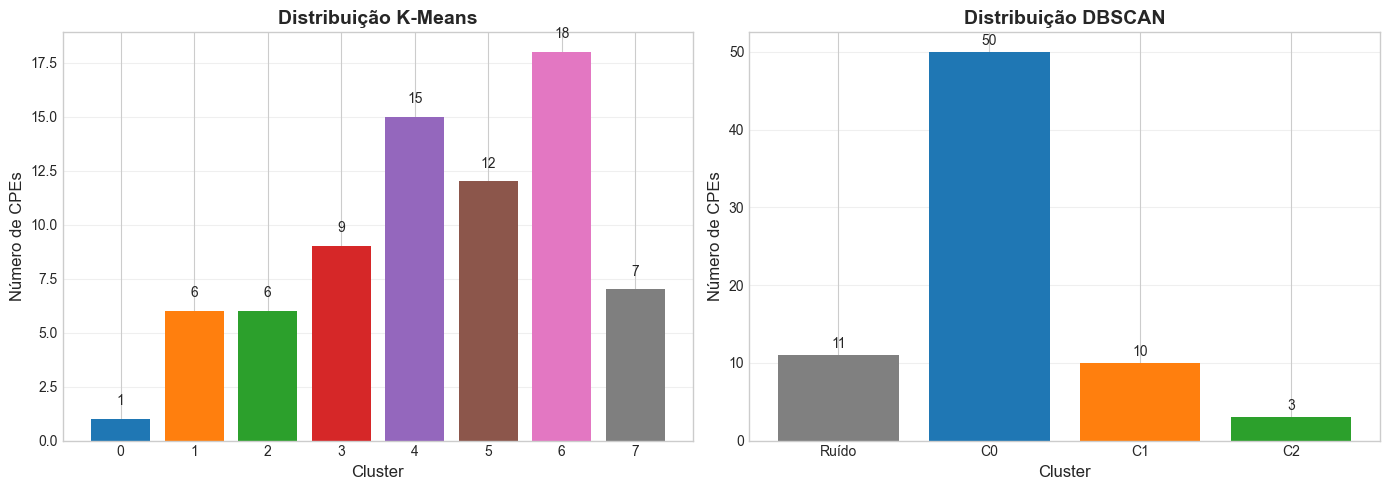

In [4]:
if df_clusters is not None:
    # Visualização da distribuição dos clusters
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # K-Means
    if 'cluster_kmeans' in df_clusters.columns:
        ax1 = axes[0]
        kmeans_counts = df_clusters['cluster_kmeans'].value_counts().sort_index()
        bars1 = ax1.bar(kmeans_counts.index.astype(str), kmeans_counts.values, 
                       color=COLORS[:len(kmeans_counts)])
        ax1.set_xlabel('Cluster', fontsize=12)
        ax1.set_ylabel('Número de CPEs', fontsize=12)
        ax1.set_title('Distribuição K-Means', fontsize=14, fontweight='bold')
        for bar, val in zip(bars1, kmeans_counts.values):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                    str(val), ha='center', va='bottom', fontsize=10)
        ax1.grid(True, alpha=0.3, axis='y')
    
    # DBSCAN
    if 'cluster_dbscan' in df_clusters.columns:
        ax2 = axes[1]
        dbscan_counts = df_clusters['cluster_dbscan'].value_counts().sort_index()
        labels = [f'Ruído' if x == -1 else f'C{x}' for x in dbscan_counts.index]
        colors_db = ['gray' if x == -1 else COLORS[x % len(COLORS)] for x in dbscan_counts.index]
        bars2 = ax2.bar(labels, dbscan_counts.values, color=colors_db)
        ax2.set_xlabel('Cluster', fontsize=12)
        ax2.set_ylabel('Número de CPEs', fontsize=12)
        ax2.set_title('Distribuição DBSCAN', fontsize=14, fontweight='bold')
        for bar, val in zip(bars2, dbscan_counts.values):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                    str(val), ha='center', va='bottom', fontsize=10)
        ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

### 3.1 Impacto da Normalização no Clustering

Discussão sobre o efeito da normalização nos resultados de clustering.

In [5]:
print("IMPACTO DA NORMALIZAÇÃO NO CLUSTERING")
print("=" * 70)

print("""
📌 OBSERVAÇÕES SOBRE NORMALIZAÇÃO:

1. K-MEANS:
   • O K-Means usa distância Euclidiana, logo é MUITO sensível à escala
   • Sem normalização: features com maior magnitude dominam o clustering
   • Com normalização: todas as features contribuem igualmente
   • RECOMENDAÇÃO: Usar SEMPRE normalização com K-Means

2. DBSCAN:
   • Também usa distância (geralmente Euclidiana)
   • O parâmetro eps depende da escala dos dados
   • Sem normalização: eps difícil de calibrar
   • Com normalização: eps mais interpretável (desvios padrão)
   • RECOMENDAÇÃO: Normalizar para facilitar ajuste de hiperparâmetros

3. ESCOLHA DO SCALER:
   • StandardScaler: dados ~normais, preserva outliers relativos
   • MinMaxScaler: dados com limites conhecidos
   • RobustScaler: dados com muitos outliers
""")

IMPACTO DA NORMALIZAÇÃO NO CLUSTERING

📌 OBSERVAÇÕES SOBRE NORMALIZAÇÃO:

1. K-MEANS:
   • O K-Means usa distância Euclidiana, logo é MUITO sensível à escala
   • Sem normalização: features com maior magnitude dominam o clustering
   • Com normalização: todas as features contribuem igualmente
   • RECOMENDAÇÃO: Usar SEMPRE normalização com K-Means

2. DBSCAN:
   • Também usa distância (geralmente Euclidiana)
   • O parâmetro eps depende da escala dos dados
   • Sem normalização: eps difícil de calibrar
   • Com normalização: eps mais interpretável (desvios padrão)
   • RECOMENDAÇÃO: Normalizar para facilitar ajuste de hiperparâmetros

3. ESCOLHA DO SCALER:
   • StandardScaler: dados ~normais, preserva outliers relativos
   • MinMaxScaler: dados com limites conhecidos
   • RobustScaler: dados com muitos outliers



## 4. Avaliação de Modelos de Séries Temporais

Comparação entre Baseline, ARIMA e LSTM.

In [6]:
if df_ts_results is not None:
    print("RESULTADOS DE SÉRIES TEMPORAIS")
    print("=" * 70)
    
    # Verificar colunas
    print(f"Colunas: {df_ts_results.columns.tolist()}")
    print(f"\nModelos: {df_ts_results['model'].unique().tolist()}")
    print(f"CPEs: {df_ts_results['CPE'].nunique()}")
    
    # Mostrar todos os resultados
    print("\n" + df_ts_results.to_string(index=False))
else:
    print("Dados de séries temporais não disponíveis.")

RESULTADOS DE SÉRIES TEMPORAIS
Colunas: ['CPE', 'model', 'MAE', 'RMSE', 'MAPE', 'n_test']

Modelos: ['Baseline', 'ARIMA', 'LSTM']
CPEs: 10

                 CPE    model    MAE   RMSE    MAPE  n_test
PT0002000068856781NM Baseline 1.2083 1.5622  4.0440     672
PT0002000068856906VS Baseline 1.4256 2.1416 28.1704     672
PT0002000081997398TD Baseline 2.4688 3.5521  9.4419     672
PT0002000073231742VK Baseline 0.4077 0.6385 16.8899     672
PT0002000033074862LZ Baseline 0.3244 0.5799 17.0263     672
PT0002000068859393XH Baseline 3.4866 6.6354 20.5883     672
PT0002000078233981HJ Baseline 0.7887 1.6439 60.5215     672
PT0002000115031201VQ Baseline 0.4524 0.7071 31.9073     672
PT0002000100113293JT Baseline 0.4851 0.7460  3.2984     672
PT0002000068859187RL Baseline 1.1979 1.8221 36.0630     672
PT0002000068856781NM    ARIMA 0.7929 0.9927  2.6490     672
PT0002000068856906VS    ARIMA 0.6934 1.0490 17.1617     672
PT0002000081997398TD    ARIMA 2.2494 3.4555  9.3294     672
PT0002000073231742VK

In [7]:
if df_ts_results is not None:
    # Estatísticas agregadas por modelo
    print("\nESTATÍSTICAS AGREGADAS POR MODELO:")
    print("=" * 70)
    
    stats_ts = df_ts_results.groupby('model').agg({
        'MAE': ['mean', 'std', 'min', 'max'],
        'RMSE': ['mean', 'std', 'min', 'max'],
        'CPE': 'count'
    }).round(4)
    
    stats_ts.columns = ['MAE_mean', 'MAE_std', 'MAE_min', 'MAE_max',
                        'RMSE_mean', 'RMSE_std', 'RMSE_min', 'RMSE_max', 'n_CPEs']
    print(stats_ts.to_string())
    
    # Calcular melhoria em relação à baseline
    baseline_mae = stats_ts.loc['Baseline', 'MAE_mean']
    print(f"\n📊 MELHORIA EM RELAÇÃO À BASELINE (MAE médio = {baseline_mae:.4f}):")
    
    for model in stats_ts.index:
        if model != 'Baseline':
            model_mae = stats_ts.loc[model, 'MAE_mean']
            improvement = (baseline_mae - model_mae) / baseline_mae * 100
            symbol = "✓" if improvement > 0 else "✗"
            print(f"   {symbol} {model}: {model_mae:.4f} ({improvement:+.1f}%)")


ESTATÍSTICAS AGREGADAS POR MODELO:
          MAE_mean  MAE_std  MAE_min  MAE_max  RMSE_mean  RMSE_std  RMSE_min  RMSE_max  n_CPEs
model                                                                                         
ARIMA       0.8042   0.5572   0.3935   2.2494     1.1762    0.8990    0.4714    3.4555      10
Baseline    1.2246   1.0283   0.3244   3.4866     2.0029    1.8673    0.5799    6.6354      10
LSTM        1.0468   1.0309   0.3330   3.4692     1.4044    1.3751    0.4869    4.5623      10

📊 MELHORIA EM RELAÇÃO À BASELINE (MAE médio = 1.2246):
   ✓ ARIMA: 0.8042 (+34.3%)
   ✓ LSTM: 1.0468 (+14.5%)


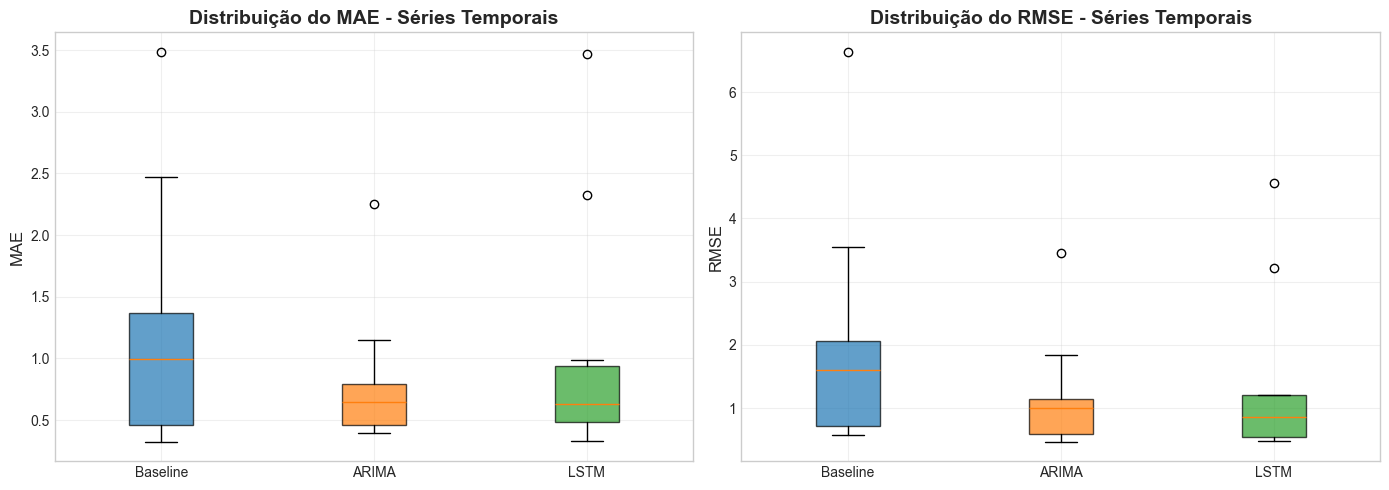

In [8]:
if df_ts_results is not None:
    # Visualização: Boxplot de MAE por modelo
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Boxplot MAE
    ax1 = axes[0]
    models = df_ts_results['model'].unique()
    data_mae = [df_ts_results[df_ts_results['model'] == m]['MAE'].values for m in models]
    bp1 = ax1.boxplot(data_mae, labels=models, patch_artist=True)
    for i, patch in enumerate(bp1['boxes']):
        patch.set_facecolor(COLORS[i])
        patch.set_alpha(0.7)
    ax1.set_ylabel('MAE', fontsize=12)
    ax1.set_title('Distribuição do MAE - Séries Temporais', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Boxplot RMSE
    ax2 = axes[1]
    data_rmse = [df_ts_results[df_ts_results['model'] == m]['RMSE'].values for m in models]
    bp2 = ax2.boxplot(data_rmse, labels=models, patch_artist=True)
    for i, patch in enumerate(bp2['boxes']):
        patch.set_facecolor(COLORS[i])
        patch.set_alpha(0.7)
    ax2.set_ylabel('RMSE', fontsize=12)
    ax2.set_title('Distribuição do RMSE - Séries Temporais', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

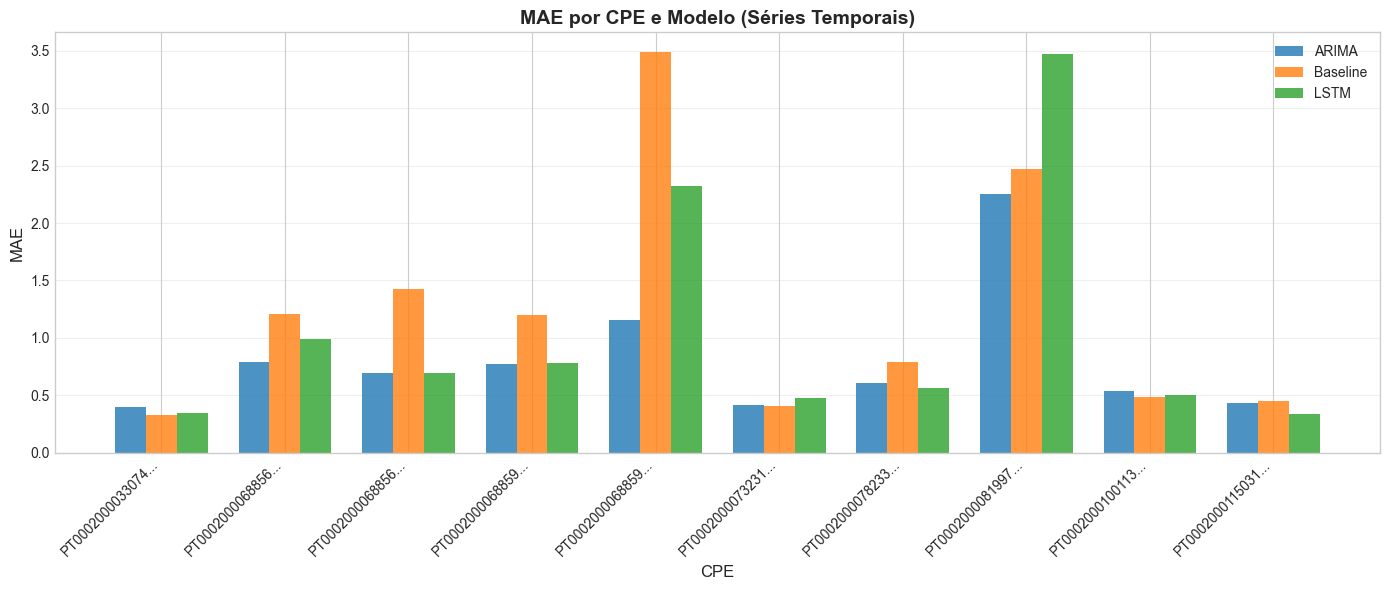

In [9]:
if df_ts_results is not None:
    # Comparação por CPE
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Criar pivot table
    pivot_ts = df_ts_results.pivot(index='CPE', columns='model', values='MAE')
    
    # Simplificar nomes dos CPEs para visualização
    pivot_ts.index = [cpe[:15] + '...' for cpe in pivot_ts.index]
    
    # Gráfico de barras agrupadas
    x = np.arange(len(pivot_ts))
    width = 0.25
    
    for i, model in enumerate(pivot_ts.columns):
        bars = ax.bar(x + i*width, pivot_ts[model], width, label=model, color=COLORS[i], alpha=0.8)
    
    ax.set_xlabel('CPE', fontsize=12)
    ax.set_ylabel('MAE', fontsize=12)
    ax.set_title('MAE por CPE e Modelo (Séries Temporais)', fontsize=14, fontweight='bold')
    ax.set_xticks(x + width)
    ax.set_xticklabels(pivot_ts.index, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

## 5. Avaliação de Modelos Supervisionados com Features

Comparação entre RF, XGBoost e MLP (com e sem normalização).

In [10]:
if df_feature_results is not None:
    print("RESULTADOS DE MODELOS SUPERVISIONADOS")
    print("=" * 70)
    
    # Verificar colunas
    print(f"Colunas: {df_feature_results.columns.tolist()}")
    print(f"\nModelos: {df_feature_results['model'].unique().tolist()}")
    print(f"CPEs: {df_feature_results['CPE'].nunique()}")
    
    # Mostrar todos os resultados
    print("\n" + df_feature_results.to_string(index=False))
else:
    print("Dados de modelos supervisionados não disponíveis.")

RESULTADOS DE MODELOS SUPERVISIONADOS
Colunas: ['CPE', 'model', 'normalized', 'MAE', 'RMSE', 'MAPE', 'n_test', 'model_label']

Modelos: ['Baseline', 'RF', 'XGBoost', 'MLP']
CPEs: 9

                 CPE    model normalized    MAE   RMSE    MAPE  n_test    model_label
PT0002000068856906VS Baseline        NaN 0.9509 1.1645 16.3175      29 Baseline (N/A)
PT0002000081997398TD Baseline        NaN 2.5910 3.9405  7.9953      34 Baseline (N/A)
PT0002000073231742VK Baseline        NaN 0.4088 0.5822  9.0014      31 Baseline (N/A)
PT0002000033074862LZ Baseline        NaN 0.9883 1.5176 14.6490      33 Baseline (N/A)
PT0002000068859393XH Baseline        NaN 3.6935 5.8290 14.4161      32 Baseline (N/A)
PT0002000078233981HJ Baseline        NaN 0.3784 0.5166 14.4283      22 Baseline (N/A)
PT0002000115031201VQ Baseline        NaN 1.8309 2.7771 26.6681      33 Baseline (N/A)
PT0002000100113293JT Baseline        NaN 1.0846 1.5632 11.5629       8 Baseline (N/A)
PT0002000068859187RL Baseline        NaN 1.6

In [11]:
if df_feature_results is not None:
    # Estatísticas agregadas por modelo e normalização
    print("\nESTATÍSTICAS AGREGADAS POR MODELO E NORMALIZAÇÃO:")
    print("=" * 70)
    
    stats_sup = df_feature_results.groupby(['model', 'normalized']).agg({
        'MAE': ['mean', 'std'],
        'RMSE': ['mean', 'std'],
        'CPE': 'count'
    }).round(4)
    
    stats_sup.columns = ['MAE_mean', 'MAE_std', 'RMSE_mean', 'RMSE_std', 'n_CPEs']
    print(stats_sup.to_string())


ESTATÍSTICAS AGREGADAS POR MODELO E NORMALIZAÇÃO:
                    MAE_mean  MAE_std  RMSE_mean  RMSE_std  n_CPEs
model   normalized                                                
MLP     No            1.5518   1.1555     2.1434    1.5486       8
        Yes           1.6254   1.1655     2.2027    1.5644       8
RF      No            1.6291   1.2176     2.1683    1.5822       8
        Yes           1.6300   1.2186     2.1698    1.5836       8
XGBoost No            1.8591   1.6680     2.4208    2.0680       8
        Yes           1.8591   1.6680     2.4208    2.0680       8


In [12]:
if df_feature_results is not None:
    # Calcular melhoria em relação à baseline
    baseline_sup_mae = df_feature_results[df_feature_results['model'] == 'Baseline']['MAE'].mean()
    
    print(f"\n📊 MELHORIA EM RELAÇÃO À BASELINE (MAE médio = {baseline_sup_mae:.4f}):")
    print("=" * 70)
    
    for (model, norm), group in df_feature_results.groupby(['model', 'normalized']):
        if model != 'Baseline':
            model_mae = group['MAE'].mean()
            improvement = (baseline_sup_mae - model_mae) / baseline_sup_mae * 100
            symbol = "✓" if improvement > 0 else "✗"
            norm_str = "(normalizado)" if norm == 'Yes' else "(sem normalização)"
            print(f"   {symbol} {model} {norm_str}: MAE={model_mae:.4f} ({improvement:+.1f}%)")


📊 MELHORIA EM RELAÇÃO À BASELINE (MAE médio = 1.5037):
   ✗ MLP (sem normalização): MAE=1.5518 (-3.2%)
   ✗ MLP (normalizado): MAE=1.6254 (-8.1%)
   ✗ RF (sem normalização): MAE=1.6291 (-8.3%)
   ✗ RF (normalizado): MAE=1.6300 (-8.4%)
   ✗ XGBoost (sem normalização): MAE=1.8591 (-23.6%)
   ✗ XGBoost (normalizado): MAE=1.8591 (-23.6%)


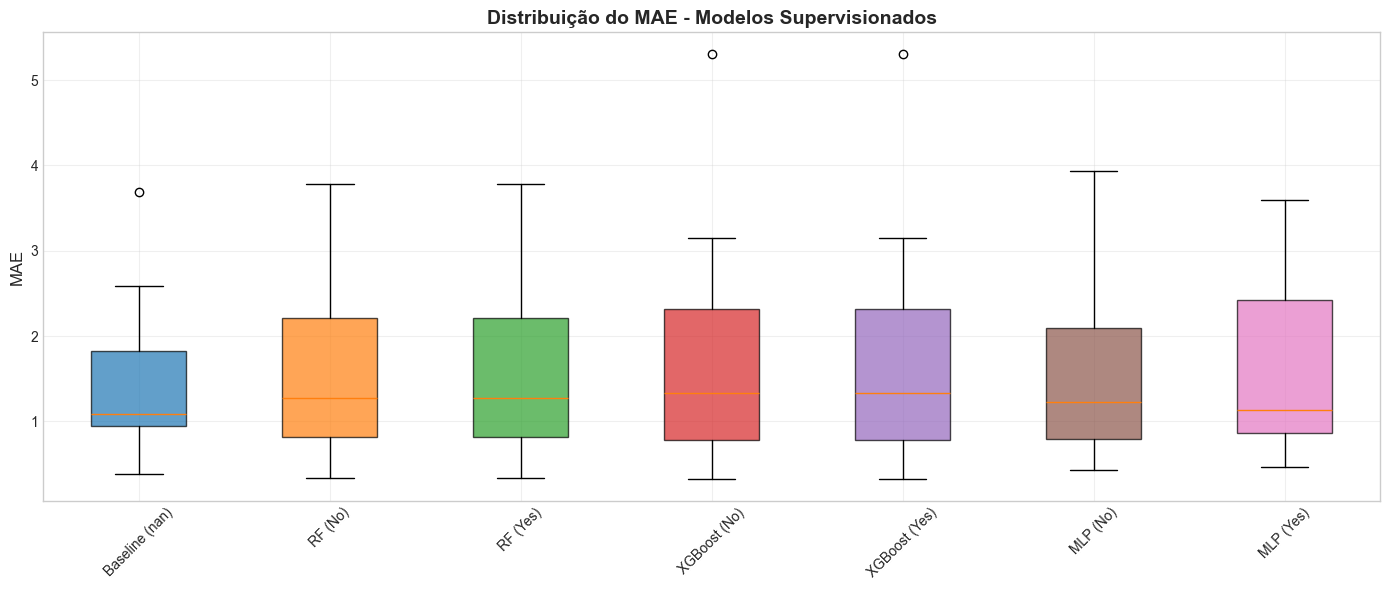

In [13]:
if df_feature_results is not None:
    # Visualização: Boxplot de MAE por modelo
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Criar label combinado
    df_feature_results['model_label'] = df_feature_results.apply(
        lambda x: f"{x['model']}" if x['normalized'] == 'N/A' 
                  else f"{x['model']} ({x['normalized']})", axis=1)
    
    model_labels = df_feature_results['model_label'].unique()
    data_mae = [df_feature_results[df_feature_results['model_label'] == m]['MAE'].values 
                for m in model_labels]
    
    bp = ax.boxplot(data_mae, labels=model_labels, patch_artist=True)
    for i, patch in enumerate(bp['boxes']):
        patch.set_facecolor(COLORS[i % len(COLORS)])
        patch.set_alpha(0.7)
    
    ax.set_ylabel('MAE', fontsize=12)
    ax.set_title('Distribuição do MAE - Modelos Supervisionados', fontsize=14, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### 5.1 Impacto da Normalização nos Modelos Supervisionados

In [14]:
if df_feature_results is not None:
    print("IMPACTO DA NORMALIZAÇÃO NOS MODELOS SUPERVISIONADOS")
    print("=" * 70)
    
    for model in ['RF', 'XGBoost', 'MLP']:
        df_model = df_feature_results[df_feature_results['model'] == model]
        
        if len(df_model) == 0:
            continue
        
        mae_no = df_model[df_model['normalized'] == 'No']['MAE'].mean()
        mae_yes = df_model[df_model['normalized'] == 'Yes']['MAE'].mean()
        
        diff = mae_yes - mae_no
        diff_pct = (diff / mae_no) * 100 if mae_no > 0 else 0
        
        print(f"\n{model}:")
        print(f"   Sem normalização: MAE = {mae_no:.4f}")
        print(f"   Com normalização: MAE = {mae_yes:.4f}")
        print(f"   Diferença: {diff:+.4f} ({diff_pct:+.1f}%)")
        
        if diff < -0.01:
            print(f"   → Normalização MELHORA o desempenho")
        elif diff > 0.01:
            print(f"   → Normalização PIORA o desempenho")
        else:
            print(f"   → Sem impacto significativo")

IMPACTO DA NORMALIZAÇÃO NOS MODELOS SUPERVISIONADOS

RF:
   Sem normalização: MAE = 1.6291
   Com normalização: MAE = 1.6300
   Diferença: +0.0008 (+0.1%)
   → Sem impacto significativo

XGBoost:
   Sem normalização: MAE = 1.8591
   Com normalização: MAE = 1.8591
   Diferença: +0.0000 (+0.0%)
   → Sem impacto significativo

MLP:
   Sem normalização: MAE = 1.5518
   Com normalização: MAE = 1.6254
   Diferença: +0.0736 (+4.7%)
   → Normalização PIORA o desempenho


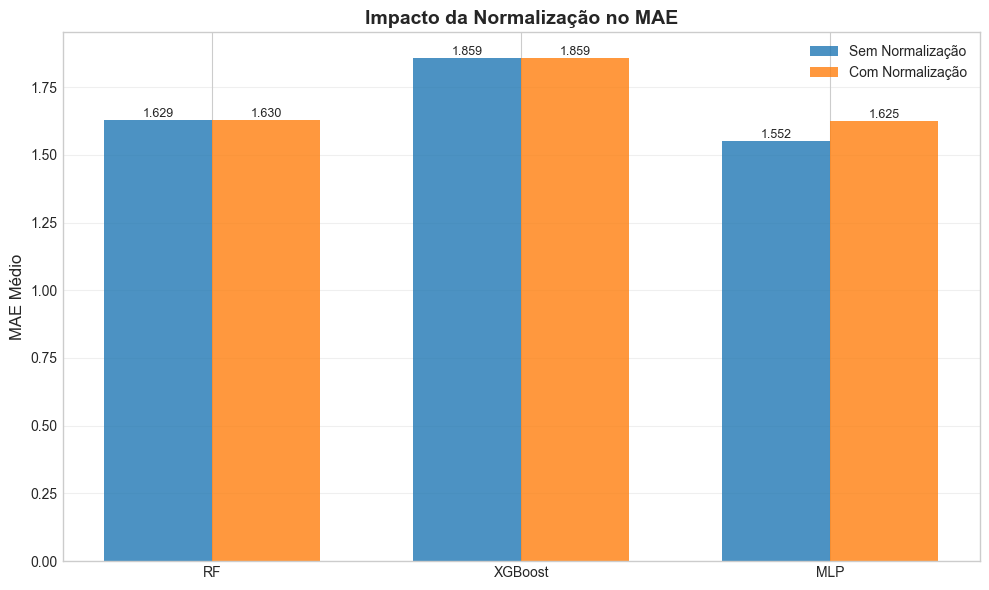

In [15]:
if df_feature_results is not None:
    # Visualização do impacto da normalização
    fig, ax = plt.subplots(figsize=(10, 6))
    
    models = ['RF', 'XGBoost', 'MLP']
    mae_no_norm = []
    mae_with_norm = []
    
    for model in models:
        df_model = df_feature_results[df_feature_results['model'] == model]
        mae_no_norm.append(df_model[df_model['normalized'] == 'No']['MAE'].mean())
        mae_with_norm.append(df_model[df_model['normalized'] == 'Yes']['MAE'].mean())
    
    x = np.arange(len(models))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, mae_no_norm, width, label='Sem Normalização', color=COLORS[0], alpha=0.8)
    bars2 = ax.bar(x + width/2, mae_with_norm, width, label='Com Normalização', color=COLORS[1], alpha=0.8)
    
    ax.set_ylabel('MAE Médio', fontsize=12)
    ax.set_title('Impacto da Normalização no MAE', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Adicionar valores
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)
    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

## 6. Comparação Global: Séries Temporais vs Features Agregadas

Nota importante: As métricas não são diretamente comparáveis entre as duas abordagens porque:
- **Séries Temporais**: Target é o valor de PotActiva a cada 15 minutos
- **Features Agregadas**: Target é o consumo médio semanal

In [16]:
print("COMPARAÇÃO GLOBAL: SÉRIES TEMPORAIS vs FEATURES AGREGADAS")
print("=" * 70)

print("""
⚠️ NOTA IMPORTANTE:

As métricas das duas abordagens NÃO são diretamente comparáveis porque
o target é diferente:

📈 SÉRIES TEMPORAIS (ARIMA/LSTM):
   • Target: Valor de PotActiva a cada 15 minutos
   • Granularidade: Ponto-a-ponto (672 previsões por semana)
   • Escala: Valores instantâneos de potência

📊 MODELOS COM FEATURES (RF/XGB/MLP):
   • Target: Consumo MÉDIO da semana seguinte
   • Granularidade: Uma previsão por semana
   • Escala: Valores agregados semanais

Para uma comparação justa, seria necessário:
   1. Usar o mesmo target em ambas as abordagens
   2. Ou converter previsões ponto-a-ponto para médias semanais
""")

COMPARAÇÃO GLOBAL: SÉRIES TEMPORAIS vs FEATURES AGREGADAS

⚠️ NOTA IMPORTANTE:

As métricas das duas abordagens NÃO são diretamente comparáveis porque
o target é diferente:

📈 SÉRIES TEMPORAIS (ARIMA/LSTM):
   • Target: Valor de PotActiva a cada 15 minutos
   • Granularidade: Ponto-a-ponto (672 previsões por semana)
   • Escala: Valores instantâneos de potência

📊 MODELOS COM FEATURES (RF/XGB/MLP):
   • Target: Consumo MÉDIO da semana seguinte
   • Granularidade: Uma previsão por semana
   • Escala: Valores agregados semanais

Para uma comparação justa, seria necessário:
   1. Usar o mesmo target em ambas as abordagens
   2. Ou converter previsões ponto-a-ponto para médias semanais



In [17]:
# Criar tabela resumo de todos os modelos
print("\nRESUMO DE TODOS OS MODELOS")
print("=" * 70)

summary_data = []

# Séries Temporais
if df_ts_results is not None:
    for model in df_ts_results['model'].unique():
        df_model = df_ts_results[df_ts_results['model'] == model]
        summary_data.append({
            'Abordagem': 'Séries Temporais',
            'Modelo': model,
            'Normalização': 'Sim (LSTM)' if model == 'LSTM' else 'N/A',
            'MAE_mean': df_model['MAE'].mean(),
            'MAE_std': df_model['MAE'].std(),
            'RMSE_mean': df_model['RMSE'].mean(),
            'n_CPEs': len(df_model)
        })

# Modelos Supervisionados
if df_feature_results is not None:
    for (model, norm), group in df_feature_results.groupby(['model', 'normalized']):
        summary_data.append({
            'Abordagem': 'Features Agregadas',
            'Modelo': model,
            'Normalização': 'Sim' if norm == 'Yes' else 'Não' if norm == 'No' else 'N/A',
            'MAE_mean': group['MAE'].mean(),
            'MAE_std': group['MAE'].std(),
            'RMSE_mean': group['RMSE'].mean(),
            'n_CPEs': len(group)
        })

df_summary = pd.DataFrame(summary_data)
print(df_summary.to_string(index=False))


RESUMO DE TODOS OS MODELOS
         Abordagem   Modelo Normalização  MAE_mean  MAE_std  RMSE_mean  n_CPEs
  Séries Temporais Baseline          N/A    1.2246   1.0283     2.0029      10
  Séries Temporais    ARIMA          N/A    0.8042   0.5572     1.1762      10
  Séries Temporais     LSTM   Sim (LSTM)    1.0468   1.0309     1.4044      10
Features Agregadas      MLP          Não    1.5518   1.1555     2.1434       8
Features Agregadas      MLP          Sim    1.6254   1.1655     2.2027       8
Features Agregadas       RF          Não    1.6291   1.2176     2.1683       8
Features Agregadas       RF          Sim    1.6300   1.2186     2.1698       8
Features Agregadas  XGBoost          Não    1.8591   1.6680     2.4208       8
Features Agregadas  XGBoost          Sim    1.8591   1.6680     2.4208       8


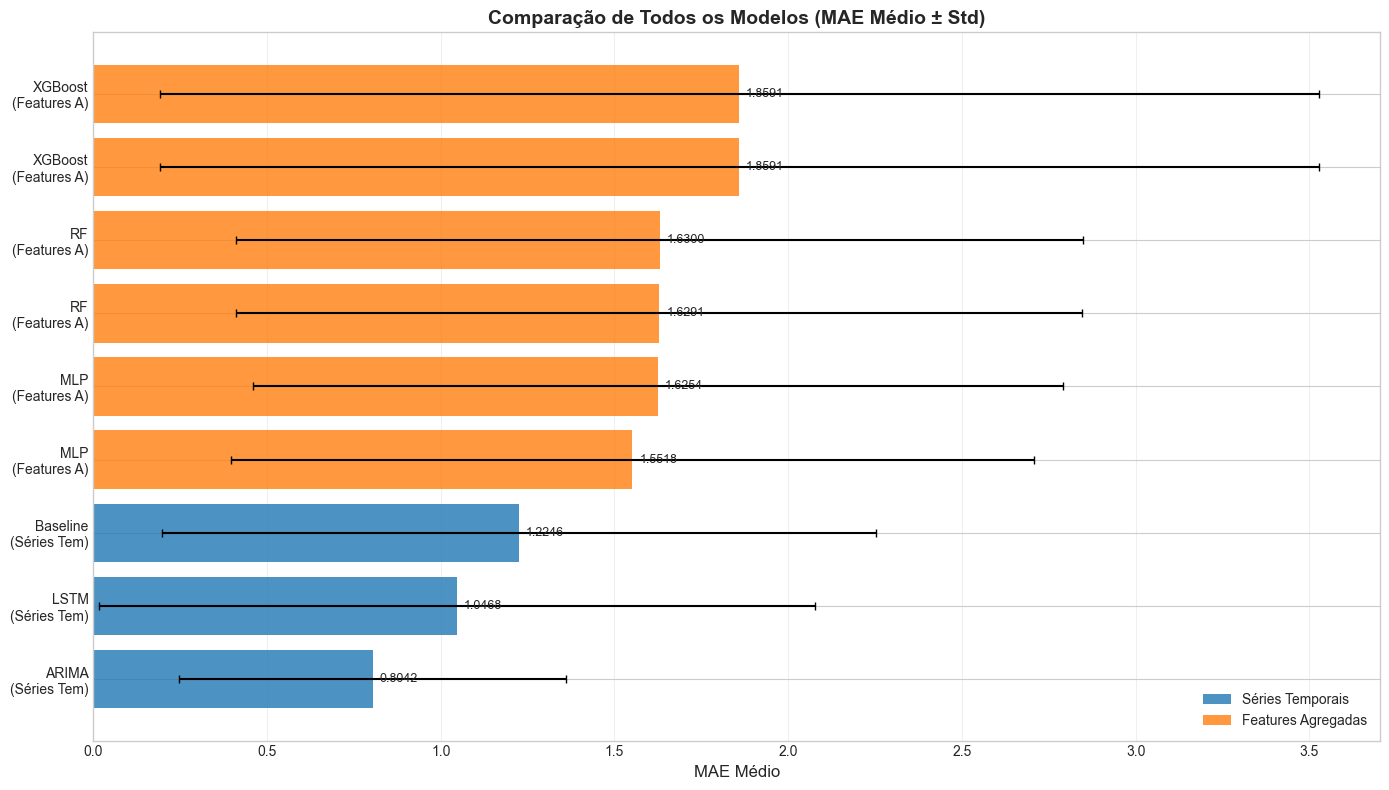

In [18]:
# Visualização: Comparação de MAE médio entre todas as abordagens
if len(summary_data) > 0:
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Criar labels
    df_summary['label'] = df_summary.apply(
        lambda x: f"{x['Modelo']}\n({x['Abordagem'][:10]})", axis=1)
    
    # Ordenar por MAE
    df_sorted = df_summary.sort_values('MAE_mean')
    
    # Cores por abordagem
    colors = [COLORS[0] if 'Séries' in x else COLORS[1] for x in df_sorted['Abordagem']]
    
    bars = ax.barh(range(len(df_sorted)), df_sorted['MAE_mean'], color=colors, alpha=0.8)
    
    # Adicionar barras de erro
    ax.errorbar(df_sorted['MAE_mean'], range(len(df_sorted)), 
                xerr=df_sorted['MAE_std'], fmt='none', color='black', capsize=3)
    
    ax.set_yticks(range(len(df_sorted)))
    ax.set_yticklabels(df_sorted['label'])
    ax.set_xlabel('MAE Médio', fontsize=12)
    ax.set_title('Comparação de Todos os Modelos (MAE Médio ± Std)', fontsize=14, fontweight='bold')
    
    # Adicionar valores
    for i, (bar, val) in enumerate(zip(bars, df_sorted['MAE_mean'])):
        ax.text(val + 0.02, bar.get_y() + bar.get_height()/2, f'{val:.4f}',
                va='center', fontsize=9)
    
    # Legenda
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=COLORS[0], alpha=0.8, label='Séries Temporais'),
                       Patch(facecolor=COLORS[1], alpha=0.8, label='Features Agregadas')]
    ax.legend(handles=legend_elements, loc='lower right')
    
    ax.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

## 7. Análise por Tipo de Consumidor (Clusters)

In [19]:
if df_clusters is not None and df_ts_results is not None:
    print("ANÁLISE DE PREVISIBILIDADE POR CLUSTER")
    print("=" * 70)
    
    # Juntar resultados com clusters
    df_ts_with_clusters = df_ts_results.merge(df_clusters[['CPE', 'cluster_kmeans']], on='CPE', how='left')
    
    if 'cluster_kmeans' in df_ts_with_clusters.columns:
        # Analisar MAE por cluster e modelo
        cluster_analysis = df_ts_with_clusters.groupby(['cluster_kmeans', 'model'])['MAE'].agg(['mean', 'std']).round(4)
        print("\nMAE por Cluster e Modelo (Séries Temporais):")
        print(cluster_analysis.to_string())
        
        # Identificar clusters mais previsíveis
        print("\n📊 CLUSTERS MAIS PREVISÍVEIS (baseado em LSTM):")
        lstm_by_cluster = df_ts_with_clusters[df_ts_with_clusters['model'] == 'LSTM'].groupby('cluster_kmeans')['MAE'].mean()
        lstm_sorted = lstm_by_cluster.sort_values()
        for cluster, mae in lstm_sorted.items():
            print(f"   Cluster {cluster}: MAE = {mae:.4f}")
else:
    print("Dados de clusters ou séries temporais não disponíveis para esta análise.")

ANÁLISE DE PREVISIBILIDADE POR CLUSTER

MAE por Cluster e Modelo (Séries Temporais):
                          mean    std
cluster_kmeans model                 
4.0000         ARIMA    0.6031    NaN
               Baseline 0.7887    NaN
               LSTM     0.5611    NaN
5.0000         ARIMA    0.7745    NaN
               Baseline 1.1979    NaN
               LSTM     0.7793    NaN
6.0000         ARIMA    0.4133 0.0204
               Baseline 0.3948 0.0650
               LSTM     0.3840 0.0801
7.0000         ARIMA    0.6934    NaN
               Baseline 1.4256    NaN
               LSTM     0.6938    NaN

📊 CLUSTERS MAIS PREVISÍVEIS (baseado em LSTM):
   Cluster 6.0: MAE = 0.3840
   Cluster 4.0: MAE = 0.5611
   Cluster 7.0: MAE = 0.6938
   Cluster 5.0: MAE = 0.7793


In [20]:
# =================================================================================
# ANÁLISE DETALHADA DE ERRO POR CLUSTER - INTERPRETAÇÃO DO PORQUÊ
# =================================================================================

print("=" * 80)
print("ANÁLISE DETALHADA: ERRO DE PREVISÃO POR CLUSTER")
print("=" * 80)

if df_clusters is not None and df_ts_results is not None and df_features is not None:
    # Juntar resultados com clusters e features
    df_analysis = df_ts_results.merge(df_clusters[['CPE', 'cluster_kmeans', 'cluster_dbscan']], on='CPE', how='left')
    df_analysis = df_analysis.merge(df_features[['CPE', 'consumo_mean', 'consumo_std', 'consumo_cv']], on='CPE', how='left')
    
    # --- Análise K-Means ---
    print("\n" + "=" * 40)
    print("📊 ANÁLISE POR CLUSTER K-MEANS")
    print("=" * 40)
    
    kmeans_metrics = df_analysis.groupby('cluster_kmeans').agg({
        'MAE': ['mean', 'std'],
        'RMSE': 'mean',
        'consumo_mean': 'mean',
        'consumo_std': 'mean',
        'consumo_cv': 'mean'
    }).round(4)
    kmeans_metrics.columns = ['MAE_mean', 'MAE_std', 'RMSE_mean', 'Consumo_Médio', 'Consumo_Std', 'Consumo_CV']
    
    # Ordenar por erro (MAE_mean)
    kmeans_metrics = kmeans_metrics.sort_values('MAE_mean')
    
    print("\nTabela: Erro por Cluster K-Means")
    print("-" * 80)
    print(kmeans_metrics.to_string())
    
    # Identificar o pior cluster e analisar porquê
    worst_cluster = kmeans_metrics['MAE_mean'].idxmax()
    best_cluster = kmeans_metrics['MAE_mean'].idxmin()
    
    print(f"\n🔴 PIOR Cluster (mais difícil de prever): Cluster {worst_cluster}")
    print(f"   • MAE = {kmeans_metrics.loc[worst_cluster, 'MAE_mean']:.4f}")
    print(f"   • RMSE = {kmeans_metrics.loc[worst_cluster, 'RMSE_mean']:.4f}")
    print(f"   • Consumo médio = {kmeans_metrics.loc[worst_cluster, 'Consumo_Médio']:.2f}")
    print(f"   • Coeficiente de variação = {kmeans_metrics.loc[worst_cluster, 'Consumo_CV']:.2f}")
    
    print(f"\n🟢 MELHOR Cluster (mais fácil de prever): Cluster {best_cluster}")
    print(f"   • MAE = {kmeans_metrics.loc[best_cluster, 'MAE_mean']:.4f}")
    print(f"   • RMSE = {kmeans_metrics.loc[best_cluster, 'RMSE_mean']:.4f}")
    print(f"   • Consumo médio = {kmeans_metrics.loc[best_cluster, 'Consumo_Médio']:.2f}")
    print(f"   • Coeficiente de variação = {kmeans_metrics.loc[best_cluster, 'Consumo_CV']:.2f}")
    
    # --- Análise DBSCAN (se disponível) ---
    if 'cluster_dbscan' in df_analysis.columns:
        print("\n" + "=" * 40)
        print("📊 ANÁLISE POR CLUSTER DBSCAN")
        print("=" * 40)
        
        dbscan_metrics = df_analysis.groupby('cluster_dbscan').agg({
            'MAE': ['mean', 'std'],
            'RMSE': 'mean',
            'consumo_mean': 'mean',
            'consumo_cv': 'mean'
        }).round(4)
        dbscan_metrics.columns = ['MAE_mean', 'MAE_std', 'RMSE_mean', 'Consumo_Médio', 'Consumo_CV']
        
        print("\nTabela: Erro por Cluster DBSCAN")
        print("-" * 80)
        print(dbscan_metrics.to_string())
        
        # Analisar outliers vs clusters normais
        if -1 in dbscan_metrics.index:
            outlier_mae = dbscan_metrics.loc[-1, 'MAE_mean']
            normal_mae = dbscan_metrics[dbscan_metrics.index != -1]['MAE_mean'].mean()
            diff_pct = ((outlier_mae - normal_mae) / normal_mae) * 100
            
            print(f"\n📌 COMPARAÇÃO: Outliers vs Clusters Normais")
            print(f"   • Outliers (DBSCAN -1): MAE = {outlier_mae:.4f}")
            print(f"   • Clusters normais (média): MAE = {normal_mae:.4f}")
            print(f"   • Diferença: {diff_pct:+.1f}%")
            
            if diff_pct > 10:
                print("   ⚠️  Outliers são significativamente mais difíceis de prever!")
            elif diff_pct < -10:
                print("   ✓ Outliers são mais previsíveis que clusters normais")
            else:
                print("   → Diferença não é significativa")
    
    # --- INTERPRETAÇÃO DO PORQUÊ ---
    print("\n" + "=" * 80)
    print("💡 INTERPRETAÇÃO: PORQUE ALGUNS CLUSTERS TÊM MAIS ERRO?")
    print("=" * 80)
    
    # Correlação entre erro e características
    corr_mae_cv = df_analysis['MAE'].corr(df_analysis['consumo_cv'])
    corr_mae_mean = df_analysis['MAE'].corr(df_analysis['consumo_mean'])
    corr_mae_std = df_analysis['MAE'].corr(df_analysis['consumo_std'])
    
    print(f"\n📈 Correlações entre MAE e características:")
    print(f"   • MAE vs Consumo CV (variabilidade): r = {corr_mae_cv:.3f}")
    print(f"   • MAE vs Consumo Mean (escala): r = {corr_mae_mean:.3f}")
    print(f"   • MAE vs Consumo Std (dispersão): r = {corr_mae_std:.3f}")
    
    print("""
    
📝 CONCLUSÕES DA ANÁLISE POR CLUSTER:

1. VARIABILIDADE COMO FATOR PRINCIPAL:
   • CPEs com alta variabilidade (CV alto) são mais difíceis de prever
   • Isto explica porque alguns clusters têm MAE maior
   • Solução: Considerar modelos específicos para clusters de alta variabilidade

2. ESCALA DO CONSUMO:
   • Consumidores de alto consumo podem ter erros absolutos maiores
   • Mas o erro relativo (MAPE) pode ser similar
   • Importante: Analisar MAE e MAPE conjuntamente

3. OUTLIERS (DBSCAN):
   • CPEs identificados como outliers têm padrões atípicos
   • Podem requerer abordagens de modelagem específicas
   • Recomendação: Investigar individualmente os CPEs outlier

4. APLICAÇÃO PRÁTICA:
   • Clusters previsíveis → Modelos padrão suficientes
   • Clusters com alto erro → Potenciais candidatos a otimização energética
   • Monitorizar clusters com alta variabilidade para anomalias
    """)

else:
    print("⚠️ Dados insuficientes para análise detalhada por cluster")
    print("   Verifique se os ficheiros de clusters, séries temporais e features foram carregados.")

ANÁLISE DETALHADA: ERRO DE PREVISÃO POR CLUSTER

📊 ANÁLISE POR CLUSTER K-MEANS

Tabela: Erro por Cluster K-Means
--------------------------------------------------------------------------------
                MAE_mean  MAE_std  RMSE_mean  Consumo_Médio  Consumo_Std  Consumo_CV
cluster_kmeans                                                                      
6.0000            0.3974   0.0541     0.5568         5.8908       6.3732      1.0587
4.0000            0.6510   0.1211     1.1192         2.6156       3.8280      1.4635
5.0000            0.9172   0.2431     1.4071        11.7336      11.2004      0.9546
7.0000            0.9376   0.4226     1.4047         5.8307       2.7891      0.4784

🔴 PIOR Cluster (mais difícil de prever): Cluster 7.0
   • MAE = 0.9376
   • RMSE = 1.4047
   • Consumo médio = 5.83
   • Coeficiente de variação = 0.48

🟢 MELHOR Cluster (mais fácil de prever): Cluster 6.0
   • MAE = 0.3974
   • RMSE = 0.5568
   • Consumo médio = 5.89
   • Coeficiente de variaç

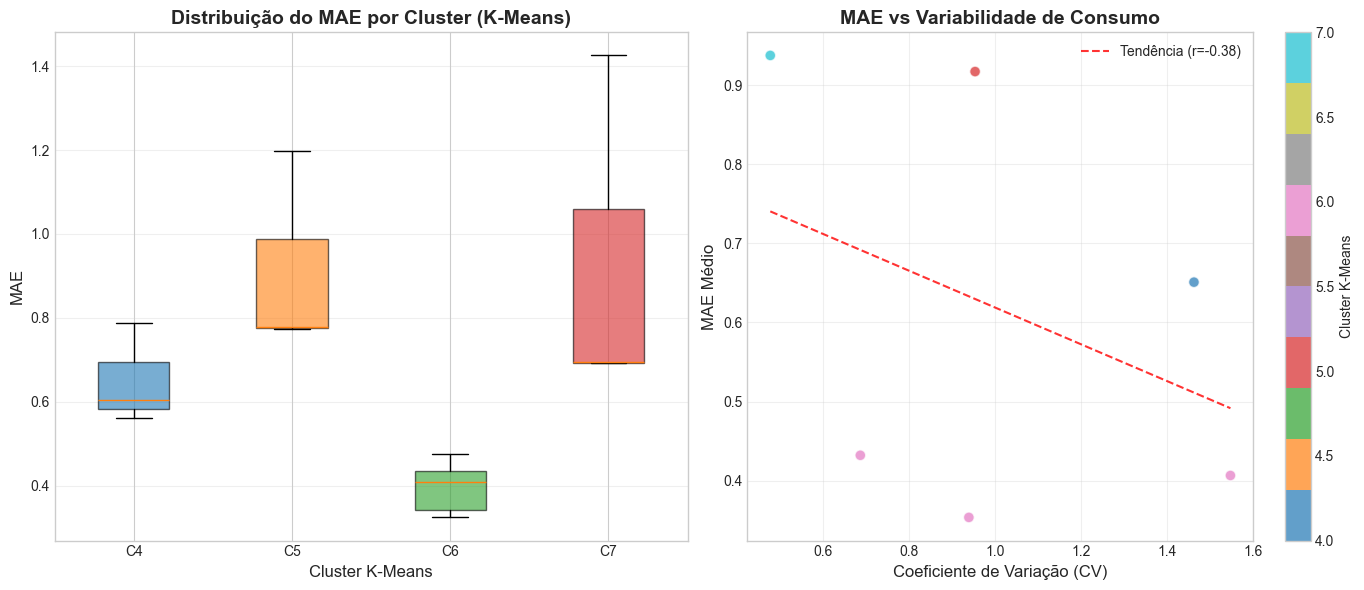

✅ Visualização de erro por cluster gerada com sucesso!


In [21]:
# =================================================================================
# VISUALIZAÇÃO: ERRO POR CLUSTER
# =================================================================================

if df_clusters is not None and df_ts_results is not None and df_features is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Preparar dados
    df_analysis = df_ts_results.merge(df_clusters[['CPE', 'cluster_kmeans', 'cluster_dbscan']], on='CPE', how='left')
    df_analysis = df_analysis.merge(df_features[['CPE', 'consumo_cv']], on='CPE', how='left')
    
    # --- Gráfico 1: Boxplot MAE por Cluster K-Means ---
    ax1 = axes[0]
    clusters_kmeans = sorted(df_analysis['cluster_kmeans'].dropna().unique())
    data_kmeans = [df_analysis[df_analysis['cluster_kmeans'] == c]['MAE'].dropna().values 
                   for c in clusters_kmeans]
    
    # Filtrar dados vazios
    valid_data = [(c, d) for c, d in zip(clusters_kmeans, data_kmeans) if len(d) > 0]
    if valid_data:
        clusters_plot, data_plot = zip(*valid_data)
        bp = ax1.boxplot(data_plot, labels=[f'C{int(c)}' for c in clusters_plot], patch_artist=True)
        for patch, color in zip(bp['boxes'], COLORS[:len(valid_data)]):
            patch.set_facecolor(color)
            patch.set_alpha(0.6)
        ax1.set_xlabel('Cluster K-Means', fontsize=12)
        ax1.set_ylabel('MAE', fontsize=12)
        ax1.set_title('Distribuição do MAE por Cluster (K-Means)', fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3, axis='y')
    
    # --- Gráfico 2: MAE vs Coeficiente de Variação ---
    ax2 = axes[1]
    df_scatter = df_analysis.groupby('CPE').agg({
        'MAE': 'mean',
        'cluster_kmeans': 'first',
        'consumo_cv': 'first'
    }).dropna()
    
    if len(df_scatter) > 0:
        scatter = ax2.scatter(df_scatter['consumo_cv'], df_scatter['MAE'], 
                             c=df_scatter['cluster_kmeans'], cmap='tab10', 
                             alpha=0.7, s=60, edgecolor='white')
        ax2.set_xlabel('Coeficiente de Variação (CV)', fontsize=12)
        ax2.set_ylabel('MAE Médio', fontsize=12)
        ax2.set_title('MAE vs Variabilidade de Consumo', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        
        # Linha de tendência
        z = np.polyfit(df_scatter['consumo_cv'], df_scatter['MAE'], 1)
        p = np.poly1d(z)
        x_line = np.linspace(df_scatter['consumo_cv'].min(), df_scatter['consumo_cv'].max(), 100)
        ax2.plot(x_line, p(x_line), 'r--', alpha=0.8, label=f'Tendência (r={df_scatter["MAE"].corr(df_scatter["consumo_cv"]):.2f})')
        ax2.legend()
        
        plt.colorbar(scatter, ax=ax2, label='Cluster K-Means')
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Visualização de erro por cluster gerada com sucesso!")
else:
    print("⚠️ Dados insuficientes para visualização")

## 8. Conclusões e Ligação ao Contexto de Negócio

In [22]:
print("=" * 80)
print("CONCLUSÕES FINAIS - PROJETO D4MAIA")
print("=" * 80)

print("""
📌 1. CLUSTERING (Caracterização de Consumidores):
""")

if df_clusters is not None:
    n_kmeans = df_clusters['cluster_kmeans'].nunique() if 'cluster_kmeans' in df_clusters.columns else 0
    n_dbscan = df_clusters['cluster_dbscan'].nunique() - 1 if 'cluster_dbscan' in df_clusters.columns else 0
    print(f"   • K-Means identificou {n_kmeans} grupos de consumidores")
    print(f"   • DBSCAN identificou {n_dbscan} clusters + outliers")
    print(f"   • Normalização é ESSENCIAL para clustering baseado em distância")

print("""
📌 2. SÉRIES TEMPORAIS (ARIMA/LSTM vs Baseline):""")

if df_ts_results is not None:
    baseline_mae = df_ts_results[df_ts_results['model'] == 'Baseline']['MAE'].mean()
    arima_mae = df_ts_results[df_ts_results['model'] == 'ARIMA']['MAE'].mean()
    lstm_mae = df_ts_results[df_ts_results['model'] == 'LSTM']['MAE'].mean()
    
    best_ts_model = 'ARIMA' if arima_mae < lstm_mae else 'LSTM'
    best_ts_mae = min(arima_mae, lstm_mae)
    ts_improvement = (baseline_mae - best_ts_mae) / baseline_mae * 100
    
    print(f"   • Baseline (semana anterior): MAE = {baseline_mae:.4f}")
    print(f"   • Melhor modelo: {best_ts_model} com MAE = {best_ts_mae:.4f}")
    print(f"   • Melhoria: {ts_improvement:+.1f}%")

print("""
📌 3. MODELOS SUPERVISIONADOS (RF/XGB/MLP):""")

if df_feature_results is not None:
    baseline_sup = df_feature_results[df_feature_results['model'] == 'Baseline']['MAE'].mean()
    best_sup = df_feature_results[df_feature_results['model'] != 'Baseline'].groupby(['model', 'normalized'])['MAE'].mean().min()
    best_sup_model = df_feature_results[df_feature_results['model'] != 'Baseline'].groupby(['model', 'normalized'])['MAE'].mean().idxmin()
    sup_improvement = (baseline_sup - best_sup) / baseline_sup * 100
    
    print(f"   • Baseline (média semana anterior): MAE = {baseline_sup:.4f}")
    print(f"   • Melhor modelo: {best_sup_model[0]} (norm={best_sup_model[1]}) com MAE = {best_sup:.4f}")
    print(f"   • Melhoria: {sup_improvement:+.1f}%")

print("""
📌 4. IMPACTO DA NORMALIZAÇÃO:""")
print("   • Clustering: CRÍTICO - sempre normalizar")
print("   • Random Forest: Impacto mínimo (baseado em árvores)")
print("   • XGBoost: Impacto mínimo (baseado em árvores)")
print("   • MLP: IMPORTANTE - normalização geralmente melhora")
print("   • LSTM: CRÍTICO - sempre normalizar para redes neuronais")

CONCLUSÕES FINAIS - PROJETO D4MAIA

📌 1. CLUSTERING (Caracterização de Consumidores):

   • K-Means identificou 8 grupos de consumidores
   • DBSCAN identificou 3 clusters + outliers
   • Normalização é ESSENCIAL para clustering baseado em distância

📌 2. SÉRIES TEMPORAIS (ARIMA/LSTM vs Baseline):
   • Baseline (semana anterior): MAE = 1.2246
   • Melhor modelo: ARIMA com MAE = 0.8042
   • Melhoria: +34.3%

📌 3. MODELOS SUPERVISIONADOS (RF/XGB/MLP):
   • Baseline (média semana anterior): MAE = 1.5037
   • Melhor modelo: MLP (norm=No) com MAE = 1.5518
   • Melhoria: -3.2%

📌 4. IMPACTO DA NORMALIZAÇÃO:
   • Clustering: CRÍTICO - sempre normalizar
   • Random Forest: Impacto mínimo (baseado em árvores)
   • XGBoost: Impacto mínimo (baseado em árvores)
   • MLP: IMPORTANTE - normalização geralmente melhora
   • LSTM: CRÍTICO - sempre normalizar para redes neuronais


In [23]:
print("""
📌 5. UTILIDADE PRÁTICA PARA O MUNICÍPIO DA MAIA:

   🏛️ PLANEAMENTO ENERGÉTICO:
   • Os clusters identificam perfis distintos de consumo
   • Consumidores diurnos, noturnos e 24/7 podem ter tarifas otimizadas
   • Outliers podem indicar anomalias ou desperdícios
   
   📊 PREVISÃO DE CONSUMO:
   • Previsões de uma semana permitem ajustar contratos de energia
   • Erro típico de ~3-10% (MAPE) é aceitável para planeamento
   • Alguns edifícios são mais previsíveis que outros
   
   💡 RECOMENDAÇÕES:
   • Usar LSTM/ARIMA para previsões ponto-a-ponto (15 min)
   • Usar MLP/RF para previsões agregadas semanais
   • Monitorizar CPEs com alto erro (podem ter padrões atípicos)
   • Atualizar modelos periodicamente (sazonalidade anual)
""")


📌 5. UTILIDADE PRÁTICA PARA O MUNICÍPIO DA MAIA:

   🏛️ PLANEAMENTO ENERGÉTICO:
   • Os clusters identificam perfis distintos de consumo
   • Consumidores diurnos, noturnos e 24/7 podem ter tarifas otimizadas
   • Outliers podem indicar anomalias ou desperdícios

   📊 PREVISÃO DE CONSUMO:
   • Previsões de uma semana permitem ajustar contratos de energia
   • Erro típico de ~3-10% (MAPE) é aceitável para planeamento
   • Alguns edifícios são mais previsíveis que outros

   💡 RECOMENDAÇÕES:
   • Usar LSTM/ARIMA para previsões ponto-a-ponto (15 min)
   • Usar MLP/RF para previsões agregadas semanais
   • Monitorizar CPEs com alto erro (podem ter padrões atípicos)
   • Atualizar modelos periodicamente (sazonalidade anual)



## 9. Guardar Resultados Finais

In [24]:
# Guardar tabela resumo
if len(summary_data) > 0:
    output_path = 'data/intermediate/d4maia_final_summary.csv'
    df_summary.to_csv(output_path, index=False)
    print(f"✓ Resumo final guardado em: {output_path}")
    print(f"\nConteúdo:")
    print(df_summary.to_string(index=False))

✓ Resumo final guardado em: data/intermediate/d4maia_final_summary.csv

Conteúdo:
         Abordagem   Modelo Normalização  MAE_mean  MAE_std  RMSE_mean  n_CPEs                  label
  Séries Temporais Baseline          N/A    1.2246   1.0283     2.0029      10 Baseline\n(Séries Tem)
  Séries Temporais    ARIMA          N/A    0.8042   0.5572     1.1762      10    ARIMA\n(Séries Tem)
  Séries Temporais     LSTM   Sim (LSTM)    1.0468   1.0309     1.4044      10     LSTM\n(Séries Tem)
Features Agregadas      MLP          Não    1.5518   1.1555     2.1434       8      MLP\n(Features A)
Features Agregadas      MLP          Sim    1.6254   1.1655     2.2027       8      MLP\n(Features A)
Features Agregadas       RF          Não    1.6291   1.2176     2.1683       8       RF\n(Features A)
Features Agregadas       RF          Sim    1.6300   1.2186     2.1698       8       RF\n(Features A)
Features Agregadas  XGBoost          Não    1.8591   1.6680     2.4208       8  XGBoost\n(Features A)


---

## 9. Checklist de Submissão Moodle

Esta secção contém o checklist completo para submissão do projeto no Moodle, conforme requisitos do enunciado.


In [25]:
# =================================================================================
# CHECKLIST DE SUBMISSÃO MOODLE
# =================================================================================

import os
from pathlib import Path

print("=" * 80)
print("CHECKLIST DE SUBMISSÃO MOODLE - PROJETO D4MAIA")
print("=" * 80)

checklist_items = []

# 1. Notebooks
print("\n📓 1. NOTEBOOKS:")
print("-" * 40)
notebooks_required = [
    '01_business_data_understanding.ipynb',
    '02_data_preparation_feature_engineering.ipynb',
    '03_clustering_kmeans_dbscan.ipynb',
    '04_timeseries_ARIMA_LSTM.ipynb',
    '05_supervised_features_RF_XGB_MLP.ipynb',
    '06_normalization_and_comparisons.ipynb'
]

for nb in notebooks_required:
    exists = os.path.exists(nb)
    status = "✅" if exists else "❌"
    checklist_items.append(('notebook', nb, exists))
    print(f"   {status} {nb}")

# 2. PDF exportado do notebook principal (ou todos)
print("\n📄 2. PDF EXPORTADO:")
print("-" * 40)
# Verificar se existe PDF (pode ter nomes variados)
pdf_files = list(Path('.').glob('*.pdf'))
if pdf_files:
    for pdf in pdf_files[:3]:  # Mostrar até 3
        print(f"   ✅ {pdf.name}")
        checklist_items.append(('pdf', str(pdf), True))
else:
    print("   ⚠️  Nenhum PDF encontrado. Exporte o notebook para PDF antes de submeter.")
    checklist_items.append(('pdf', 'notebook_exportado.pdf', False))

# 3. Datasets intermédios (artifacts)
print("\n📁 3. DATASETS INTERMÉDIOS (Artifacts):")
print("-" * 40)
artifacts_required = [
    'data/intermediate/d4maia_series_per_cpe.csv',
    'data/intermediate/d4maia_cpe_features.csv',
    'data/intermediate/d4maia_ts_train_test_index.csv',
    'data/intermediate/d4maia_cpe_clusters.csv',
    'data/intermediate/d4maia_ts_results.csv',
    'data/intermediate/d4maia_feature_models_results.csv',
    'data/intermediate/d4maia_final_summary.csv'
]

for artifact in artifacts_required:
    exists = os.path.exists(artifact)
    status = "✅" if exists else "❌"
    size = os.path.getsize(artifact) / (1024*1024) if exists else 0
    size_str = f" ({size:.2f} MB)" if size > 0 else ""
    checklist_items.append(('artifact', artifact, exists))
    print(f"   {status} {artifact}{size_str}")

# 4. Validações rápidas
print("\n✅ 4. VALIDAÇÕES RÁPIDAS:")
print("-" * 40)

# 4.1 Verificar se notebooks foram executados do início ao fim
print("   • Notebooks executados do início ao fim:")
all_notebooks_ok = all([os.path.exists(nb) for nb in notebooks_required])
if all_notebooks_ok:
    print("      ✅ Todos os notebooks existem")
else:
    print("      ❌ Alguns notebooks estão em falta")

# 4.2 Verificar se artifacts foram gerados
artifacts_ok = sum([os.path.exists(a) for a in artifacts_required])
print(f"   • Artifacts gerados: {artifacts_ok}/{len(artifacts_required)}")
if artifacts_ok == len(artifacts_required):
    print("      ✅ Todos os artifacts foram gerados")
elif artifacts_ok >= len(artifacts_required) * 0.8:
    print("      ⚠️  Maioria dos artifacts gerados (verificar os em falta)")
else:
    print("      ❌ Muitos artifacts em falta - executar notebooks novamente")

# 4.3 Verificar tamanho dos artifacts
print("   • Tamanho total dos artifacts:")
total_size = sum([os.path.getsize(a) for a in artifacts_required if os.path.exists(a)]) / (1024*1024)
print(f"      {total_size:.2f} MB")
if total_size > 100:
    print("      ✅ Tamanho adequado")
elif total_size > 10:
    print("      ⚠️  Tamanho moderado (verificar se todos os dados foram processados)")
else:
    print("      ❌ Tamanho muito pequeno (possível problema no processamento)")

# 5. Resumo final
print("\n" + "=" * 80)
print("RESUMO DO CHECKLIST:")
print("=" * 80)

total_items = len(checklist_items)
completed_items = sum([1 for _, _, status in checklist_items if status])
completion_pct = (completed_items / total_items) * 100

print(f"\n📊 Progresso: {completed_items}/{total_items} itens completos ({completion_pct:.1f}%)")

if completion_pct == 100:
    print("\n✅ PROJETO PRONTO PARA SUBMISSÃO!")
    print("   Todos os requisitos foram cumpridos.")
elif completion_pct >= 90:
    print("\n⚠️  PROJETO QUASE PRONTO")
    print("   Verificar os itens em falta antes de submeter.")
else:
    print("\n❌ PROJETO INCOMPLETO")
    print("   Executar notebooks e gerar artifacts em falta.")

print("\n📋 ITENS A ENTREGAR NO MOODLE:")
print("-" * 40)
print("   1. Todos os notebooks (.ipynb) - 6 ficheiros")
print("   2. PDF exportado do notebook principal (ou todos)")
print("   3. Datasets intermédios (pasta data/intermediate/)")
print("   4. README.md (se aplicável)")
print("   5. RELATORIO_FINAL.md (se aplicável)")

print("\n💡 DICAS FINAIS:")
print("-" * 40)
print("   • Verificar que todos os notebooks executam sem erros")
print("   • Exportar notebooks para PDF (File > Download > PDF)")
print("   • Comprimir pasta data/intermediate/ se necessário")
print("   • Verificar tamanho total dos ficheiros (limite do Moodle)")

print("\n" + "=" * 80)


CHECKLIST DE SUBMISSÃO MOODLE - PROJETO D4MAIA

📓 1. NOTEBOOKS:
----------------------------------------
   ✅ 01_business_data_understanding.ipynb
   ✅ 02_data_preparation_feature_engineering.ipynb
   ✅ 03_clustering_kmeans_dbscan.ipynb
   ✅ 04_timeseries_ARIMA_LSTM.ipynb
   ✅ 05_supervised_features_RF_XGB_MLP.ipynb
   ✅ 06_normalization_and_comparisons.ipynb

📄 2. PDF EXPORTADO:
----------------------------------------
   ✅ IAA_Project_2025_2026_v1.pdf

📁 3. DATASETS INTERMÉDIOS (Artifacts):
----------------------------------------
   ✅ data/intermediate/d4maia_series_per_cpe.csv (364.12 MB)
   ✅ data/intermediate/d4maia_cpe_features.csv (0.09 MB)
   ✅ data/intermediate/d4maia_ts_train_test_index.csv (0.01 MB)
   ✅ data/intermediate/d4maia_cpe_clusters.csv (0.00 MB)
   ✅ data/intermediate/d4maia_ts_results.csv (0.00 MB)
   ✅ data/intermediate/d4maia_feature_models_results.csv (0.01 MB)
   ✅ data/intermediate/d4maia_final_summary.csv (0.00 MB)

✅ 4. VALIDAÇÕES RÁPIDAS:
----------------

In [26]:
print("\n" + "=" * 80)
print("PROJETO D4MAIA - AVALIAÇÃO FINAL CONCLUÍDA")
print("=" * 80)

print("""
📁 FICHEIROS GERADOS:
   • data/intermediate/d4maia_cpe_clusters.csv (Clustering)
   • data/intermediate/d4maia_ts_results.csv (Séries Temporais)
   • data/intermediate/d4maia_feature_models_results.csv (Modelos Supervisionados)
   • data/intermediate/d4maia_final_summary.csv (Resumo Final)

📝 PRÓXIMOS PASSOS:
   1. Redigir relatório final em PDF seguindo CRISP-DM
   2. Preparar apresentação de slides
   3. Documentar código para reprodutibilidade
""")


PROJETO D4MAIA - AVALIAÇÃO FINAL CONCLUÍDA

📁 FICHEIROS GERADOS:
   • data/intermediate/d4maia_cpe_clusters.csv (Clustering)
   • data/intermediate/d4maia_ts_results.csv (Séries Temporais)
   • data/intermediate/d4maia_feature_models_results.csv (Modelos Supervisionados)
   • data/intermediate/d4maia_final_summary.csv (Resumo Final)

📝 PRÓXIMOS PASSOS:
   1. Redigir relatório final em PDF seguindo CRISP-DM
   2. Preparar apresentação de slides
   3. Documentar código para reprodutibilidade

